In [1]:
import warnings
import pickle, os
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from xgboost import XGBRegressor
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/TreeSegmentation/satellite_tree_coverage.csv")
df

,Timestamp,L0001,L0002,L0003,L0004,L0005,L0006,L0007,L0008,L0009,L0010,L0011,L0012,L0013,L0014,L0015,L0016,L0017,L0018,L0019,L0020,L0021,L0022,L0023,L0024,L0025,L0026,L0027,L0028,L0029,L0030,L0031,L0032,L0033,L0034,L0035,L0036,L0037,L0038,L0039,L0040,L0041,L0042,L0043,L0044,L0045,L0046,L0047,L0048,L0049,...,L0951,L0952,L0953,L0954,L0955,L0956,L0957,L0958,L0959,L0960,L0961,L0962,L0963,L0964,L0965,L0966,L0967,L0968,L0969,L0970,L0971,L0972,L0973,L0974,L0975,L0976,L0977,L0978,L0979,L0980,L0981,L0982,L0983,L0984,L0985,L0986,L0987,L0988,L0989,L0990,L0991,L0992,L0993,L0994,L0995,L0996,L0997,L0998,L0999,L1000
0,2014-01-01,21.653063,20.315667,40.813313,52.368722,20.358192,30.714614,62.555801,28.313895,29.366956,68.400654,55.665810,56.652790,38.470662,42.041960,45.275729,67.209388,60.056908,64.759260,49.560940,53.530078,61.591988,31.052119,33.215921,38.164989,52.983282,41.617144,53.135512,46.769641,36.630578,48.901545,58.266473,44.428117,32.894056,35.932230,46.855282,29.490239,44.155277,57.387005,65.830412,40.626912,66.233169,24.821264,57.966523,58.386086,22.078157,40.836601,48.505212,47.719069,28.881687,...,20.763836,26.471996,55.847154,49.052568,51.079316,66.224318,24.508876,46.139094,37.212277,59.199148,26.794739,28.914227,62.777895,52.681628,50.340261,29.227259,32.731629,39.553512,48.015123,62.878638,59.250363,63.252925,28.259644,54.569438,62.651894,58.592933,26.881557,25.728223,20.568254,67.881481,38.686146,69.132525,41.333173,51.722599,56.375684,51.556952,46.476832,58.483032,26.311611,39.993399,67.487480,50.579797,64.984516,24.794133,56.825393,54.806482,57.112627,64.840227,53.751142,39.845026
1,2014-02-01,21.757015,20.139602,40.909049,51.957309,19.837510,30.447563,62.455819,28.610109,29.737122,67.519238,55.298627,56.373730,38.400829,42.429720,44.930881,67.477649,60.225640,65.520317,49.938046,53.113836,60.365573,31.034551,32.726143,38.091514,53.194701,41.229216,51.906664,45.705095,36.571959,47.498277,58.618744,44.612513,33.208395,34.488936,46.798960,28.430347,44.465270,57.767738,64.915985,39.965118,65.695356,24.179663,57.779680,58.029103,21.549379,39.520051,48.723944,48.128824,29.127305,...,20.988415,26.920454,55.695975,49.338751,50.160168,65.009044,24.505390,45.051300,36.955918,59.212422,27.527732,28.718934,63.246202,53.429098,50.367531,28.060514,32.306955,39.684141,48.142825,62.577605,59.485903,63.323674,28.546008,54.807769,62.371653,58.223834,27.353249,25.666030,21.046635,67.441596,38.176009,68.778991,40.908198,51.390759,55.896890,51.472516,46.931070,58.039008,26.703902,40.095625,67.970241,50.892583,65.120792,24.912683,57.501862,54.216542,57.141340,64.982129,54.116845,40.205236
2,2014-03-01,21.332034,20.099019,40.914453,52.316471,19.157643,29.962871,62.475204,29.034306,30.172695,66.858359,54.567945,55.032810,38.779313,42.762410,45.344100,67.853919,59.911046,65.135431,50.211766,53.565162,60.117089,30.655638,32.352133,38.284578,53.321730,40.126760,51.301914,45.256260,35.387379,46.878222,59.062074,44.616348,33.163083,34.136466,45.505559,27.178857,44.402682,58.076953,63.525558,39.785314,64.573211,23.518854,58.224478,58.482529,20.982534,39.501990,49.043654,47.721229,28.850738,...,21.284746,27.336483,55.300000,49.546496,49.832306,64.875270,24.893604,44.221015,36.716416,59.358172,27.846469,28.872535,63.597380,53.927207,49.883007,27.092780,30.930678,39.324536,48.089902,61.285670,59.586655,63.446824,28.118764,54.987915,61.770152,57.873048,27.283660,25.040874,21.195822,66.975190,36.788709,69.117767,41.026295,51.715059,56.352646,51.422476,47.117034,57.640335,26.689921,39.731773,67.961523,50.445467,65.457053,25.296290,58.294036,52.921671,57.576158,64.613841,54.597012,40.618821
3,2014-04-01,21.496293,20.557717,41.339632,52.103633,17.705551,30.028687,62.443516,28.715939,30.491609,65.609208,53.310935,54.900407,39.212326,43.169394,44.971953,68.297320,59.760789,65.439712,50.095718,53.433808,59.318633,30.888460,32.408343,38.486135,53.804277,39.332686,51.123797,44.329284,33.903822,45.859321,58.892469,44.637555,33.566257,32.952022,44.800850,27.0717

In [3]:
def timeseries_data_pipeline(
                            selective_window = 12,
                            prediction_window = 3,
                            data_path = "data/TreeSegmentation/satellite_tree_coverage.csv"
                            ):
    df = pd.read_csv(data_path)
    del df['Timestamp']

    X, Y = [], []

    for i in range(selective_window, len(df)-prediction_window):
        X.append(df.iloc[i-selective_window:i].values)
        Y.append(df.iloc[i:i+prediction_window].values)

    X, Y = np.array(X), np.array(Y)

    return X, Y

In [4]:
X, Y = timeseries_data_pipeline(selective_window=12, prediction_window=3)
print(f"{X.shape=}, {Y.shape=}")

X.shape=(117, 12, 1000), Y.shape=(117, 3, 1000)


In [5]:
input_layer = tf.keras.layers.Input(shape=(X.shape[1], X.shape[2]))
lstm_layer = tf.keras.layers.LSTM(256, return_sequences=True)(input_layer)
lstm_layer = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_layer)
dense_layer = tf.keras.layers.Dense(32)(lstm_layer)

o1_layer = tf.keras.layers.Dense(Y.shape[2], name='day01')(dense_layer)
o2_layer = tf.keras.layers.Dense(Y.shape[2], name='day02')(dense_layer)
o3_layer = tf.keras.layers.Dense(Y.shape[2], name='day03')(dense_layer)

model = tf.keras.models.Model(
                            inputs=input_layer, 
                            outputs=[o1_layer, o2_layer, o3_layer]
                            )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1000)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 12, 256)      1287168     ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          197120      ['lstm[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 32)           4128        ['lstm_1[0][0]']                 
                                                                                              

In [6]:
model.compile(
            loss='mse', 
            optimizer='adam',
            metrics=['mae', 'mse']
            )

In [7]:
Y_modified = [Y[:, i, :].squeeze() for i in range(Y.shape[1])]
history = model.fit(
                X, 
                Y_modified, 
                epochs=100, 
                batch_size=32
                )

Epoch 1/100
4/4 [==============================] - 5s 16ms/step - loss: 5413.3643 - day01_loss: 1806.1982 - day02_loss: 1803.9071 - day03_loss: 1803.2590 - day01_mae: 35.7946 - day01_mse: 1806.1982 - day02_mae: 35.7149 - day02_mse: 1803.9071 - day03_mae: 35.6599 - day03_mse: 1803.2590
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 5379.1030 - day01_loss: 1794.9341 - day02_loss: 1791.8640 - day03_loss: 1792.3049 - day01_mae: 35.6408 - day01_mse: 1794.9341 - day02_mae: 35.5475 - day02_mse: 1791.8640 - day03_mae: 35.5108 - day03_mse: 1792.3049
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 5307.3398 - day01_loss: 1771.0452 - day02_loss: 1767.3802 - day03_loss: 1768.9146 - day01_mae: 35.3076 - day01_mse: 1771.0452 - day02_mae: 35.2012 - day02_mse: 1767.3802 - day03_mae: 35.1831 - day03_mse: 1768.9146
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 5194.2202 - day01_loss: 1733.3058 - day02_loss: 1729.1130 - day03_loss

In [8]:
model.save("artifacts/model_forecast.h5")

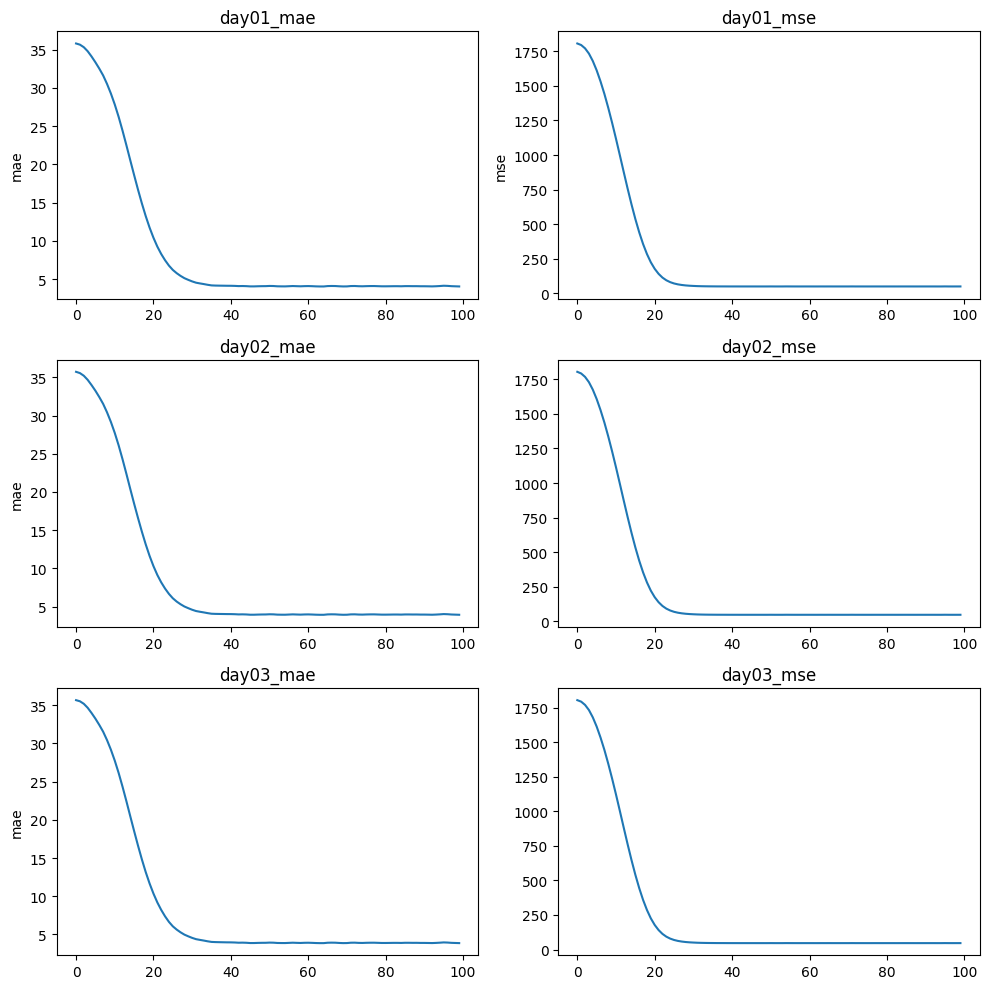

In [13]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.plot(history.history['day01_mae'])
plt.title('day01_mae')
plt.ylabel('mae')

plt.subplot(3, 2, 2)
plt.plot(history.history['day01_mse'])
plt.title('day01_mse')
plt.ylabel('mse')

plt.subplot(3, 2, 3)
plt.plot(history.history['day02_mae'])
plt.title('day02_mae')
plt.ylabel('mae')

plt.subplot(3, 2, 4)
plt.plot(history.history['day02_mse'])
plt.title('day02_mse')

plt.subplot(3, 2, 5)
plt.plot(history.history['day03_mae'])
plt.title('day03_mae')
plt.ylabel('mae')

plt.subplot(3, 2, 6)
plt.plot(history.history['day03_mse'])
plt.title('day03_mse')

plt.tight_layout()

plt.show()

In [5]:
model_forecast = tf.keras.models.load_model('artifacts/model_forecast.h5')
model_forecast.compile(
                    loss='mse', 
                    optimizer='adam',
                    metrics=['mae', 'mse']
                    )

In [6]:
def inference_forecast(   
                        location_id,                                 
                        selective_window=12,
                        data_path = "data/TreeSegmentation/satellite_tree_coverage.csv"
                        ):
    df = pd.read_csv(data_path)
    del df['Timestamp']

    df = df.iloc[-selective_window:]
    X = np.array(df.values).reshape(1, selective_window, df.shape[1])

    Y_pred = model_forecast.predict(X)
    Y_pred = np.array(Y_pred).squeeze()
    vals = (
            round(Y_pred[0][location_id], 2), 
            round(Y_pred[1][location_id], 2), 
            round(Y_pred[2][location_id], 2)
            )
    return vals

In [13]:

inference_forecast(location_id=100)

1/1 [==============================] - 0s 19ms/step


(42.98, 42.88, 42.79)

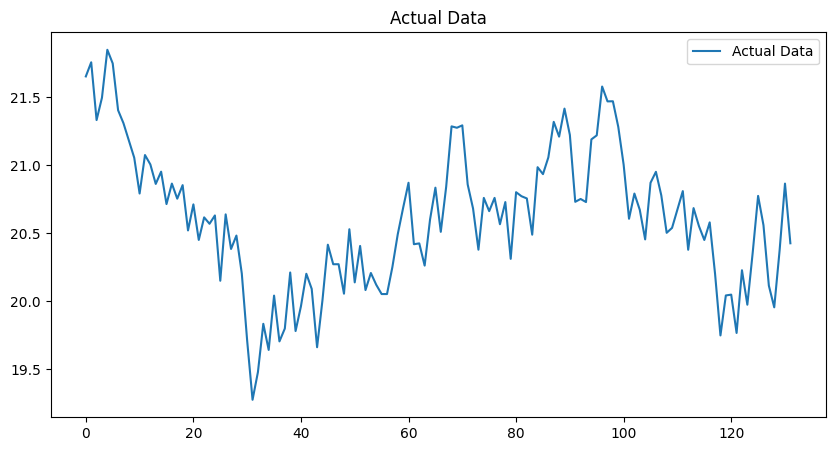

In [14]:
df = pd.read_csv("data/TreeSegmentation/satellite_tree_coverage.csv")
L0001 = df['L0001'].values

# plot the actual data
plt.figure(figsize=(10, 5))
plt.plot(L0001, label='Actual Data')
plt.title('Actual Data')
plt.legend()
plt.show()